<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/causality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Granger Causality**

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import numpy as np
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import lag_plot
import scipy
from statsmodels.tsa.stattools import adfuller
from functools import reduce

from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Relevance**

In order to determine whether one time series causes another, the most common approach is the so-called **Granger causality test**.

The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another, first proposed in 1969. Ordinarily, regressions reflect "mere" correlations, but Clive Granger argued that causality in economics could be tested for by measuring the ability to predict the future values of a time series using prior values of another time series.

Granger defined the causality relationship based on two principles:

* The cause happens prior to its effect.
* The cause has unique information about the future values of its effect.


A time series X is said to **Granger-cause** Y if it can be shown, usually through a series of t-tests and F-tests on lagged values of X (and with lagged values of Y also included), that those X values provide statistically significant information about future values of Y.

If a time series is a **stationary process**, the test is performed using the level values of two (or more) variables. If the variables are non-stationary, then the test is done using first (or higher) differences. The number of lags to be included is usually chosen using an information criterion, such as the Akaike information criterion or the Schwarz information criterion. 

# **Import & Preprocessing**

**Import data**

In [0]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/google.csv'
data = pd.read_csv(url)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-02-01,266.301849,266.904572,264.159851,265.514771,265.514771,4518400
1,2010-02-02,266.481171,266.481171,262.819885,264.568329,264.568329,8223000
2,2010-02-03,263.347900,270.037842,263.128723,269.400208,269.400208,6020500
3,2010-02-04,267.497345,267.995483,261.798706,262.406433,262.406433,6780600
4,2010-02-05,263.213409,265.753876,260.254517,264.653015,264.653015,6335600


**Preprocess Original Series**

In [0]:
series = data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
series = series.rename(columns={"Date": "date", "Close": "price"})
series = series.set_index('date')
series.head()

,price
date,
2010-02-01,265.514771
2010-02-02,264.568329
2010-02-03,269.400208
2010-02-04,262.406433
2010-02-05,264.653015


**Create Additional Series for Granger Causality Test**

* We are adding a series that is simply a copy of the original series but shifted by t-1. This is a 'ideal case' since in financial time series the previous time step determines to a strong degree the next one.
* Let's also add some gaussian noise with eight standard deviations and a non-zero mean to the new time series, so that it's not exactly a 1:1 of the original time series

In [0]:
# First value is the mean of the distribution to choose from
# Second value is the standard deviation of the distribution
# Third value is the number of elements that are in array noise

noise = (np.random.normal(20,8,2516))

In [0]:
series = series.rename(columns={"price": "present"})
series['past'] = ((series.present).shift(-1) + (noise))
series = series.dropna()
series.head()

,present,past
date,,
2010-02-01,265.514771,295.935376
2010-02-02,264.568329,282.229573
2010-02-03,269.400208,272.201496
2010-02-04,262.406433,296.802490
2010-02-05,264.653015,298.362601


**Difference both Series for Stationarity in Granger Causality Test**

(Granger causality requires stationary time series as input)

In [0]:
differenced = series
differenced = differenced.drop(columns=['present', 'past'])
differenced['present'] = ((series.present) - ((series.present).shift(1)))
differenced['past'] = ((series.past) - ((series.past).shift(1)))
differenced = differenced.dropna()
differenced.head()

,present,past
date,,
2010-02-02,-0.946442,-13.705803
2010-02-03,4.831879,-10.028076
2010-02-04,-6.993775,24.600993
2010-02-05,2.246582,1.560111
2010-02-08,1.085938,-3.947636


# **Exploratory Data Analysis**

Since both series originate in the same time series (just one was shifted and enriched with some gaussian noise), we will continue analyzing only the 'present' data time series:

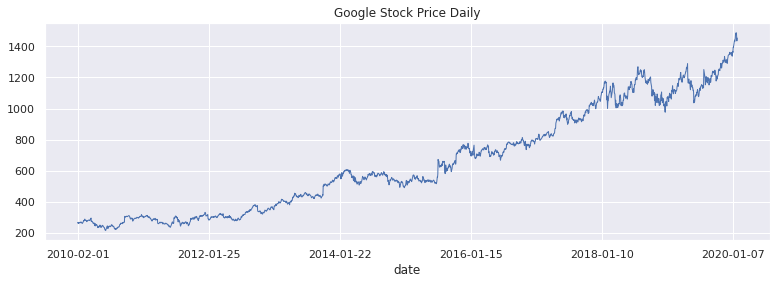

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
series.present.plot(linewidth=1.0,title='Google Stock Price Daily')

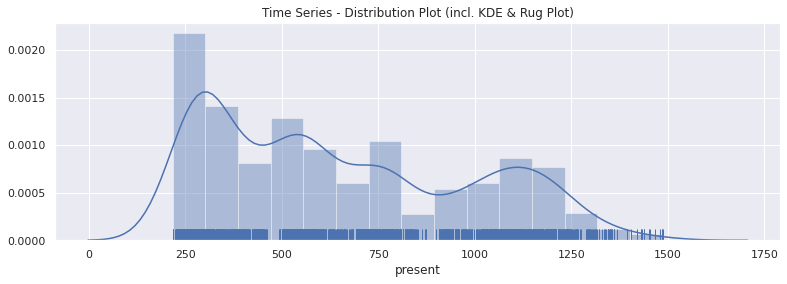

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((series.present), hist=True, rug=True).set_title('Time Series - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

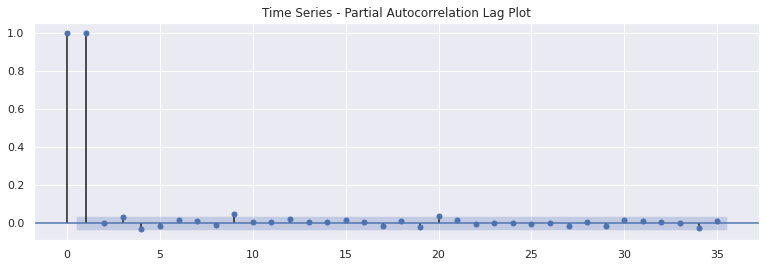

In [0]:
plot_pacf(series.present)
plt.title('Time Series - Partial Autocorrelation Lag Plot')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


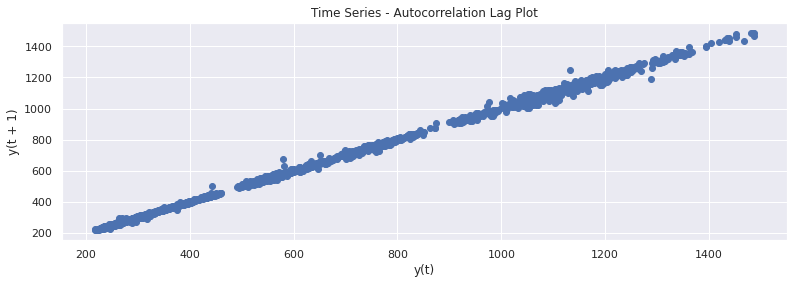

In [0]:
lag_plot(series)
plt.title('Time Series - Autocorrelation Lag Plot')
plt.show()

# **Stationarity Test**

Granger causality (1969) requires both series to be stationary, so let's test whether this is true for both time series, and difference them until they are stationary.

**Stationarity Test (Past)**

In [0]:
# Augmented Dicker Fuller test. H0: There is a unit root for the series (non stationary)
statsmodels.tsa.stattools.adfuller(series.past, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(2.876401597978606,
 0.9996357456576557,
 20,
 2492,
 {'1%': -2.5666377750631875,
  '10%': -1.616713854334163,
  '5%': -1.9411083247565093},
 18900.642828184118)

p-value above 0.05. Not reject H0. Series is not stationary Transformation for Granger test required (difference time series).

In [0]:
statsmodels.tsa.stattools.adfuller(differenced.past, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-11.307906843205679,
 1.672093316997256e-20,
 17,
 2496,
 {'1%': -2.5666363353866184,
  '10%': -1.616714023745387,
  '5%': -1.9411081502986165},
 18858.655293548058)

Past series is now stationary. They have been a unit root before, since it had to be differenced once only.

**Stationarity Test (Present)**

In [0]:
statsmodels.tsa.stattools.adfuller(series.present, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(2.9203780191829734,
 0.9997075998411147,
 20,
 2494,
 {'1%': -2.566637054647272,
  '10%': -1.616713939107425,
  '5%': -1.941108237457268},
 18859.519137810224)

p-value above 0.05. Not reject H0. Series is not stationary Transformation for Granger test required (difference time series).

In [0]:
statsmodels.tsa.stattools.adfuller(differenced.present, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-11.307906843205679,
 1.672093316997256e-20,
 17,
 2496,
 {'1%': -2.5666363353866184,
  '10%': -1.616714023745387,
  '5%': -1.9411081502986165},
 18858.655293548058)

Past series is now stationary. They have been a unit root before, since it had to be differenced once only.

# **Simple Regression**

Before conducting the Granger causality test, let's first simply regress one time series (past) on the other (present) to see if there is any relationship between them:

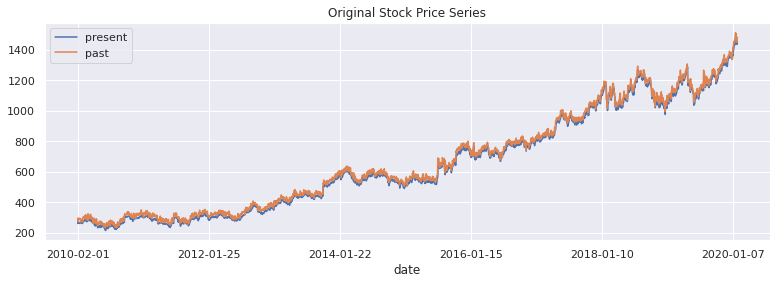

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
series.plot(linewidth=1.5,title='Original Stock Price Series')

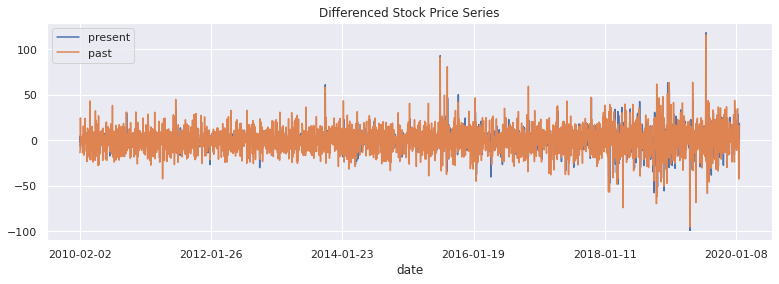

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
differenced.plot(linewidth=1.5,title='Differenced Stock Price Series')

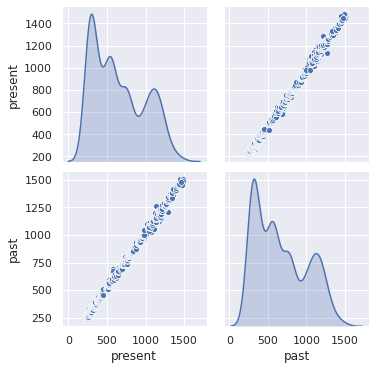

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.pairplot(series, diag_kind='kde')

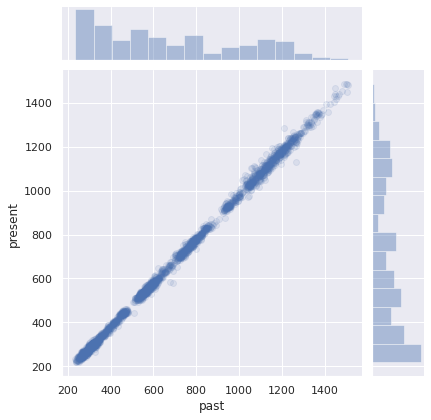

In [0]:
sns.jointplot(x="past", y="present", data=series, alpha=0.1);

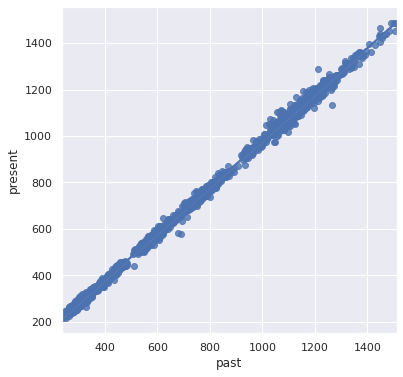

In [0]:
# Plot data and a linear regression model fit
sns.set(rc={'figure.figsize':(6, 6)})
sns.regplot(x="past", y="present", data=series);

There is a clear linear relationship between both series.
Note that if the distribution of the time series is not normal, the application of **robust regression** is recommendable.

# **Causality Test**

Ordinarily, regressions reflect "mere" correlations, but Clive Granger argued that causality in economics could be tested for by measuring the ability to predict the future values of a time series using prior values of another time series. The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another, first proposed in 1969.

Granger defined the causality relationship based on two principles:

* The cause happens prior to its effect.
* The cause has unique information about the future values of its effect.


A time series X is said to **Granger-cause** Y if it can be shown, usually through a series of t-tests and F-tests on lagged values of X (and with lagged values of Y also included), that those X values provide statistically significant information about future values of Y.

If a time series is a **stationary process**, the test is performed using the level values of two (or more) variables. If the variables are non-stationary, then the test is done using first (or higher) differences. The number of lags to be included is usually chosen using an information criterion, such as the Akaike information criterion or the Schwarz information criterion. 

## **Johansen Cointegration**

Let's first run a **cointegration test**. If two time series, X and Y, are cointegrated, there must exist Granger causality either from X to Y, or from Y to X, both in both directions. (However note that the presence of Granger causality in either or both directions between X and Y does not necessarily imply that the series will be cointegrated.)

In [0]:
# Johansen Cointegration. H0: There is no cointegration.
statsmodels.tsa.stattools.coint(differenced.past, differenced.present, trend='ct', method='aeg', autolag='aic')

(-17.874097452300084,
 8.302854719859784e-35,
 array([-4.33376918, -3.78435647, -3.49912914]))

Very small p-value. Reject H0. Cointegration present. Granger causality must exit.

## **Granger Causality Test**

Granger causality require stationary data and data in same scale (or normalized) (Granger causality (1969) requires both series to be stationary. Toda-Yamamoto causality requies no such criteria, the test can be applied to both stationary and non stationary data.)

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. **Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors**. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

However note that:
* Granger causality cannot take into account third hidden factors affecting both series
* Granger can also not differentiate no-linear relationships (when two factors cause each other). Please see CCM (Convergent Cross Mapping) as a more advanced approach for non-linear relationships.


In [0]:
# Granger Causality
# Null hypothesis: x2 does NOT Granger cause x1
# Reject null hypothesis if the p-values are below 0.05
statsmodels.tsa.stattools.grangercausalitytests(differenced, maxlag = 5, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2134.3221, p=0.0000  , df_denom=2510, df_num=1
ssr based chi2 test:   chi2=2136.8731, p=0.0000  , df=1
likelihood ratio test: chi2=1546.4064, p=0.0000  , df=1
parameter F test:         F=2134.3221, p=0.0000  , df_denom=2510, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1438.9165, p=0.0000  , df_denom=2507, df_num=2
ssr based chi2 test:   chi2=2883.5726, p=0.0000  , df=2
likelihood ratio test: chi2=1920.4227, p=0.0000  , df=2
parameter F test:         F=1438.9165, p=0.0000  , df_denom=2507, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1058.6844, p=0.0000  , df_denom=2504, df_num=3
ssr based chi2 test:   chi2=3184.9320, p=0.0000  , df=3
likelihood ratio test: chi2=2056.6877, p=0.0000  , df=3
parameter F test:         F=1058.6844, p=0.0000  , df_denom=2504, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=85

{1: ({'lrtest': (1546.4063779633398, 0.0, 1),
   'params_ftest': (2134.3220940880933, 0.0, 2510.0, 1.0),
   'ssr_chi2test': (2136.873076670669, 0.0, 1),
   'ssr_ftest': (2134.3220940880938, 0.0, 2510.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (1920.4227093319278, 0.0, 2),
   'params_ftest': (1438.916519703835, 0.0, 2507.0, 2.0),
   'ssr_chi2test': (2883.5726346198912, 0.0, 2),
   'ssr_ftest': (1438.916519703835, 0.0, 2507.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (2056.687652620567, 0.0, 3),
   'params_ftest': (1058.6844044465547, 0.0, 2504.0, 3.0),
   'ssr_chi2test': (3184.9319563482027, 0.0, 3),
   'ssr_ftest': (1058.684404446555, 0.0, 2504.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])]),
 4: ({'lrtest': (2166.7655569384187, 0.0, 4),
   'params_ftest': (857.1308841634456, 0.0, 2501.0, 4.0),
   'ssr_chi2test': (3440.8612862858877, 0.0, 4),
   's

Excellent result: p-value is zero. Reject H0. It can be rejected that x2 (past values) does not Granger cause x1 (present values of same time series). Or in layman's terms: there is a strong indication that past price value cause the present price values.